In [105]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
# Load the dataset
df = pd.read_csv("Area8.csv")
df.drop("Index",axis=1,inplace=True)
df.head()

,DT,A1
0,01/04/20,22.14
1,02/04/20,29.69
2,03/04/20,20.26
3,04/04/20,25.06
4,05/04/20,25.00


In [107]:
df['DT'] = pd.to_datetime(df['DT'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DT      1248 non-null   datetime64[ns]
 1   A1      1248 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


/var/folders/6y/n8bwhyg95ts66g4gc8gct2nm0000gn/T/ipykernel_17772/3746817318.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DT'] = pd.to_datetime(df['DT'])


In [108]:
df['Timestamp'] = df['DT'].values.astype(np.int64) // 10**9
df = df.sort_values(by='DT')
df.head()

,DT,A1,Timestamp
0,2020-01-04,22.14,1578096000
30,2020-01-05,1.32,1578182400
61,2020-01-06,29.62,1578268800
91,2020-01-07,24.62,1578355200
122,2020-01-08,20.12,1578441600


In [109]:
df['DT'] = pd.to_datetime(df['DT'])
df['day_of_week'] = df['DT'].dt.dayofweek
df['month'] = df['DT'].dt.month
df['hour'] = df['DT'].dt.hour

In [110]:
q1 = df.A1.quantile(0.25)
q3 = df.A1.quantile(0.75)
IQR = q3-q1
upper_limit = q3+1.5*IQR
lower_limit = q1-1.5*IQR
df = df[df.A1<upper_limit]

<Axes: >

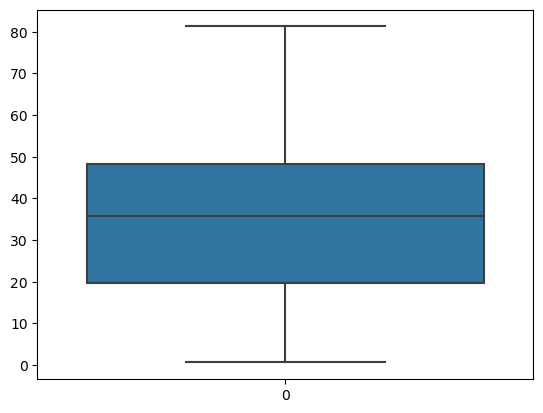

In [111]:
sns.boxplot(df.A1)

In [112]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['day_of_week', 'month', 'hour']].values,
    df['A1'].values,
    test_size=0.2,
    random_state=42
)

In [113]:
# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2'
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

In [114]:
# Build and train the RandomForestRegressor with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=50, random_state=42)

In [115]:
# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

In [116]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 18.468069846825088


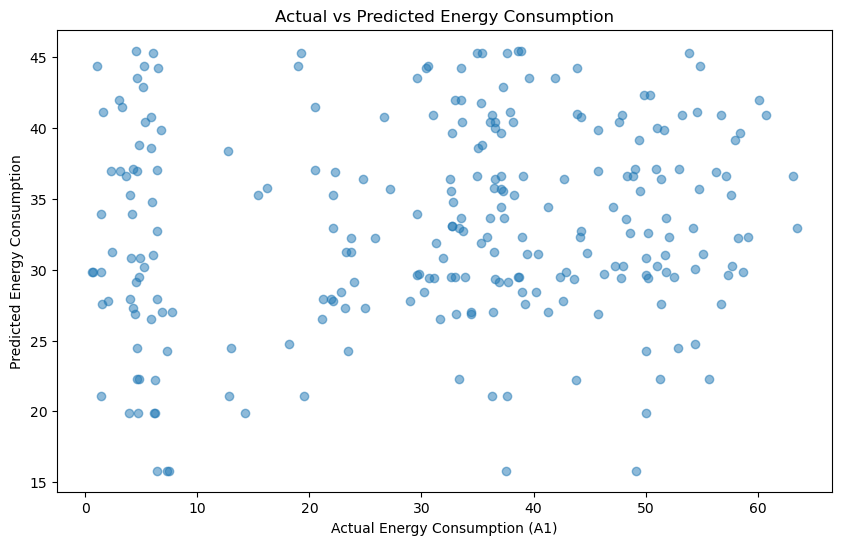

In [117]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Energy Consumption (A1)")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

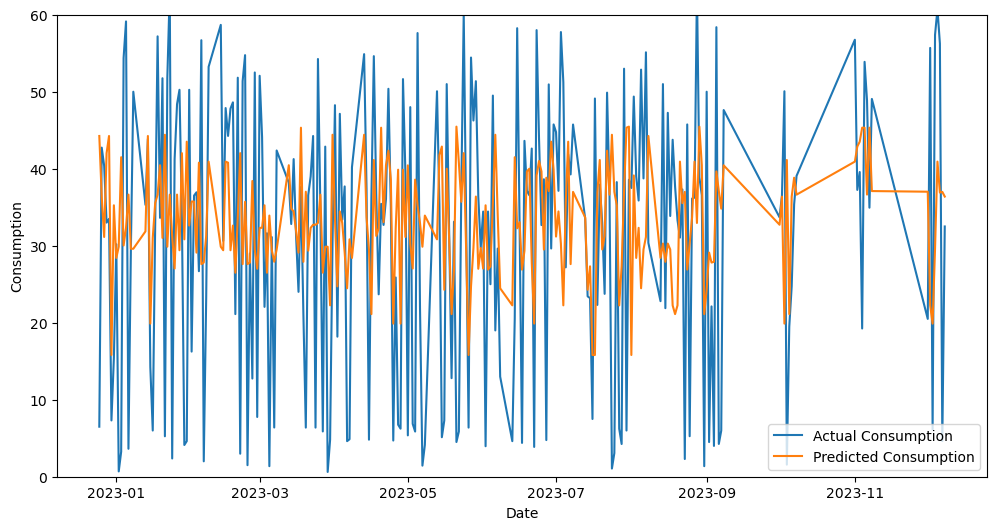

In [118]:
# Plot the actual vs predicted consumption
plt.figure(figsize=(12, 6))
plt.plot(df['DT'].iloc[-len(y_test):], y_test, label='Actual Consumption')
plt.plot(df['DT'].iloc[-len(y_test):], y_pred, label='Predicted Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.ylim(0,60)
plt.show()

In [119]:
user_input = '2029-01-20 00:00:00'
user_datetime = pd.to_datetime(user_input)
user_day_of_week = user_datetime.dayofweek
user_month = user_datetime.month
user_hour = user_datetime.hour
predicted_energy_consumption_rf = best_rf_model.predict([[user_day_of_week, user_month, user_hour]])
print(f'Predicted consumption for {user_input} : {predicted_energy_consumption_rf[0]}')

Predicted consumption for 2029-01-20 00:00:00 : 32.32323865602407


In [120]:
import pickle

# Assuming best_rf_model is already trained
# ...

# Export the trained model to a .pkl file
with open('Model8.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)
